# County adjacency and death rates

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import pickle
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import *
from src.utils.dates import get_today, lag_date, date2str, str2date, get_format
from src.utils.df_utils import get_date_columns
from src.pandas.align import align_lagged_dates

from scipy.stats import spearmanr

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Time series data
mobility, mobility_date = load_google_mobility()
deaths, deaths_date = load_deaths(join_county_codes=False)
interventions, interventions_date = load_interventions()

# Static data
counties, counties_date = load_counties()

# Processed mobility -> time series
mobility_ts, mobility_ts_date = load_google_mobility_time_series()

m50,_ = load_descartes_m50()

od_mobility = load_od_baseline()

hospitals = load_acute_care(beds=True)

print(f'Mobility Last Updated {mobility_ts_date}')
print(f'Deaths Last Updated {deaths_date}')

# County adjacency edge list
with open('../data/processed/county_adjacency_edge_dict.pkl', 'rb') as f:
    county_adj = pickle.load(f)

Mobility Last Updated 05-08
Deaths Last Updated 05-26


In [3]:
N_DAYS = 14

In [4]:
# Get death dataframe date columns
death_dates = get_date_columns(mobility_ts, return_dtimes=False)

In [5]:
def get_onset_date(row, thresh = 5):
    above = row[row > thresh]
    if len(above) == 0:
        return np.nan
    else:
        return above.idxmin()

In [6]:
## Normalize deaths by pop total
deaths_df = deaths[['FIPS']+death_dates]

deaths_df['onset'] = deaths_df[death_dates].apply(lambda row: get_onset_date(row), axis=1)

## New date range
deaths_df = deaths_df.dropna(axis=0, subset=['onset'])

n_days = 28
deaths_df = deaths_df[deaths_df['onset'].apply(lambda d: (str2date(death_dates[-1]) - str2date(d)).days >= n_days)]
# deaths_df = deaths_df[deaths_df['onset'].apply(lambda d: (str2date(death_dates[-1]) - str2date(d)).days >= n_days)]
deaths_df['cum_deaths'] = deaths_df.apply(
    lambda r: sum(r[[d for d in death_dates if 
        str2date(d) >= str2date(r['onset']) and 
        str2date(d) < lag_date(str2date(r['onset']
    ), 
    lag=n_days, backwards=False)]]), axis=1)

In [7]:
def normalize(row, cols, target='cum_deaths'):
    """
    Normalizes target column by column cols
    norm_type : list of len(cols)
     - 1 to multiply target by (i.e. density)
     - -1 to divide target by (i.e. total pop)
    """
    r = row[target]
    for col,norm_type in cols.items():
        if pd.isnull(row[col]):
            r = np.nan
            break
        r *= int(row[col])**(norm_type)

    return r

In [9]:
cum_deaths = deaths_df[['FIPS', 'cum_deaths']]
cum_deaths = pd.merge(cum_deaths, hospitals, on='FIPS')

m50_dates = get_date_columns(m50, return_dtimes=False)
m50['baseline'] = m50.apply(lambda x: x[m50_dates[:7]].mean(), axis=1)
cum_deaths = pd.merge(cum_deaths, m50[['FIPS', 'baseline']], on='FIPS')
cum_deaths.rename(columns={'baseline':'m50'}, inplace=True)
cum_deaths = pd.merge(cum_deaths, od_mobility, on='FIPS')

confounder_dict = {
    'POP_ESTIMATE_2018' : -1,
    'Density per square mile of land area - Population': 0,
    'Rural-urban_Continuum Code_2013': 0,
    'Total_age65plus': 0,
}
cum_deaths = pd.merge(cum_deaths, counties[['FIPS'] + list(confounder_dict.keys())], on='FIPS')
cum_deaths['normalized_deaths'] = cum_deaths.apply(
    lambda row: normalize(row, confounder_dict), axis=1
    )
for col in ['inter_movement', 'in_movement', 'out_movement']:
    cum_deaths[col] = cum_deaths.apply(lambda row: row[col] / row['POP_ESTIMATE_2018'], axis=1)

cum_deaths.dropna(axis=0, inplace=True)

In [10]:
log_cols = ['normalized_deaths', 'HospCt', 'm50', 'Beds', 'inter_movement', 'in_movement', 'out_movement','Density per square mile of land area - Population']
# cum_deaths['Beds'] = cum_deaths['Beds'] + 1
# cum_deaths['HospCt'] = cum_deaths['HospCt'] + 1
cum_deaths[[lc + ' (log)' for lc in log_cols]] = cum_deaths[log_cols].transform('log')

In [11]:
urban_outbreaks = cum_deaths[cum_deaths['Rural-urban_Continuum Code_2013'] == 1.0]['FIPS']

In [12]:
adj_outbreaks = []
for fip in urban_outbreaks:
    if fip not in county_adj.keys():
        print(f'Count {fip} not present')
        continue
    adj_fips = []
    for adj_fip in county_adj[fip]:
        if adj_fip in urban_outbreaks:
            continue
        try:
            adj_fips.append(adj_fip)
        except:
            pass
    adj_outbreaks.append((fip, adj_fips))

Text(0.5, 1.0, 'Number of RUCC > 1 outbreaks neghboring RUCC 1 outbreaks')

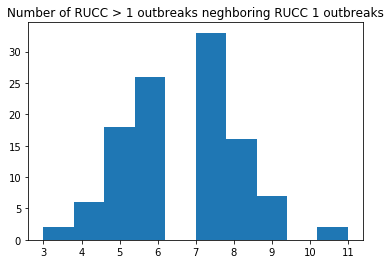

In [13]:
plt.hist([len(a[1]) for a in adj_outbreaks])
plt.title('Number of RUCC > 1 outbreaks neghboring RUCC 1 outbreaks')

In [ ]:
nbr_df = cum_deaths[urban_outbreaks]
nbr_df['nbr_avg'] = nbr_df.apply(lambda )